In [ ]:
from bs4 import BeautifulSoup
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from sklearn.model_selection import KFold, cross_validate, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import joblib
import csv

In [204]:
with open("realestate.html", "r") as f:
    doc = BeautifulSoup(f, "html.parser")

### Data Acquisition
---
First, I created a scraping script to scrape realestate.com.au website. The website itself has a anti scraping system so what I did was to manually copy each page's html, save it to local, and scrape the saved html page.

In [ ]:
datasets = []
property_cards = doc.find_all(class_="residential-card__content")
k = 0
j = -1
for property in property_cards:
    address = property.find('h2').span.text.split(', ')
    information = property.find_all(class_="Text__Typography-sc-1103tao-0 ljPIrY")
    sold_date = datetime.strptime(property.find("span", attrs={"class": None, "aria-hidden":None}).text[8:], '%d %b %Y')
    price = property.find(class_="property-price").text[1:].replace(',','')
    state = doc.find(class_='styles__BreadcrumbLink-sc-mq2383-1 hBskMP', href="/sold/in-vic/list-1").span.text
    postcodes = doc.find_all(class_='LinkBase-sc-1ba0r3r-0 Button__ButtonWithLinkVariant-sc-etylg7-0 comat lmXSzs LocationSummary__Container-sc-31kjw6-0 Cofxu')
    if k % 25 == 0:
        j += 1
    postcode = postcodes[j].find("span", class_="Button__LabelWithMargin-sc-etylg7-1 ihTytr").text
    data = []
    for addr in address:
        data.append(addr)
    data.append(state)
    data.append(postcode)
    data.append(sold_date)
    if len(information) < 5:
        i = 0
        for info in information:
            i += 1
            if i == 4:
                data.append(None)
            data.append(info.text.replace('m²', ''))
    else:
        for info in information:
            data.append(info.text.replace('m²', ''))
    data.append(price)
    datasets.append(data)
    k += 1

From the scraping script, I scraped 3 suburbs, with 75 entry for each suburb and scraped 11 colums. 'address', 'suburb', 'state', 'postcode', 'date_sold', 'bedroom', 'bathroom', 'carspace', 'size', 'type', and 'price' then save it to csv file.

In [ ]:
columns = ['address', 'suburb', 'state', 'postcode', 'date_sold', 'bedroom', 'bathroom', 'carspace', 'size', 'type', 'price']

with open('dataset.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(columns)     # Write header
    writer.writerows(datasets)      # Write data rows

First, load the dataset and drop address and state column as we will not be needing them.

In [ ]:
df = pd.read_csv("dataset.csv")

# Drop columns we won't use
df = df.drop(columns=["address", "state"])

Data cleaning

In [210]:
# - Parse date
df["date_sold"] = pd.to_datetime(df["date_sold"], errors="coerce")

# - Numeric columns: coerce numeric, strip commas in size
numeric_like = ["bedroom","bathroom","carspace","size","price"]
for col in numeric_like:
    if col in df.columns:
        df[col] = (
            df[col]
            .astype(str)
            .str.replace(",", "", regex=False)
        )
        df[col] = pd.to_numeric(df[col], errors="coerce")

# - Basic missing value cleaning
for col in numeric_like:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

for col in ["suburb","postcode","type"]:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].mode()[0])

Feature analysis

In [ ]:
# Time-based features
df["sale_year"]  = df["date_sold"].dt.year
df["sale_month"] = df["date_sold"].dt.month
df["sale_dow"]   = df["date_sold"].dt.dayofweek  # 0=Mon
df["is_weekend"] = (df["sale_dow"] >= 5).astype(int)

# Structural features
df["rooms_total"]    = df["bedroom"] + df["bathroom"]
df["rooms_total"]    = df["rooms_total"].replace(0, 1)  # avoid div by zero
df["size_per_room"]  = df["size"] / df["rooms_total"]
df["carspace_per_rm"] = df["carspace"] / df["rooms_total"]

# Frequency encoding (counts) – how common a suburb/postcode in data
if "suburb" in df.columns:
    suburb_counts = df["suburb"].value_counts()
    df["suburb_freq"] = df["suburb"].map(suburb_counts)
if "postcode" in df.columns:
    pcode_counts = df["postcode"].value_counts()
    df["postcode_freq"] = df["postcode"].map(pcode_counts)

Encoding and standardizing

In [212]:
target = "price"
y = df[target].copy()

# Choose features (exclude target & raw date)
base_features = [
    "suburb","postcode","type",
    "bedroom","bathroom","carspace","size",
    "sale_year","sale_month","sale_dow","is_weekend",
    "rooms_total","size_per_room","carspace_per_rm",
    "suburb_freq","postcode_freq"
]
X = df[base_features].copy()

categorical_features = [c for c in ["suburb","postcode","type"] if c in X.columns]
numeric_features = [c for c in X.columns if c not in categorical_features]

# Preprocess: impute + scale numerics; impute + OHE categoricals
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe",     OneHotEncoder(handle_unknown="ignore", drop=None, sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num",  numeric_transformer, numeric_features),
        ("cat",  categorical_transformer, categorical_features)
    ],
    remainder="drop"
)

Visualization

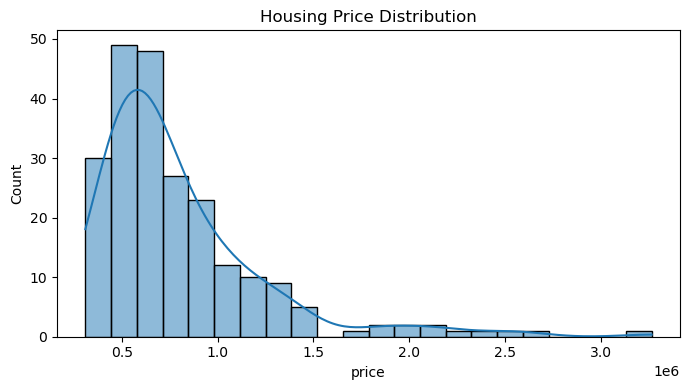

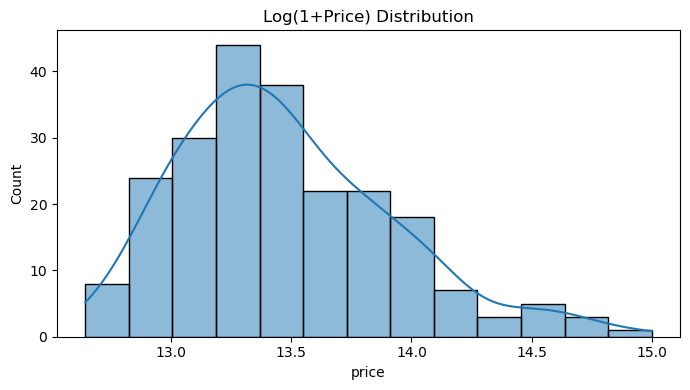

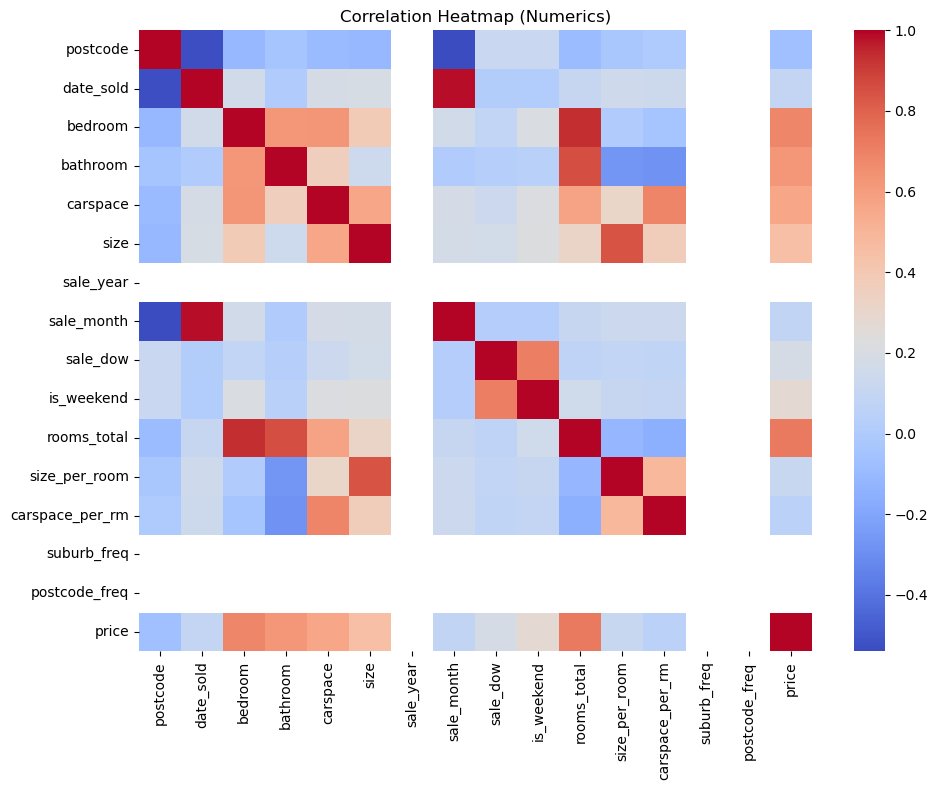

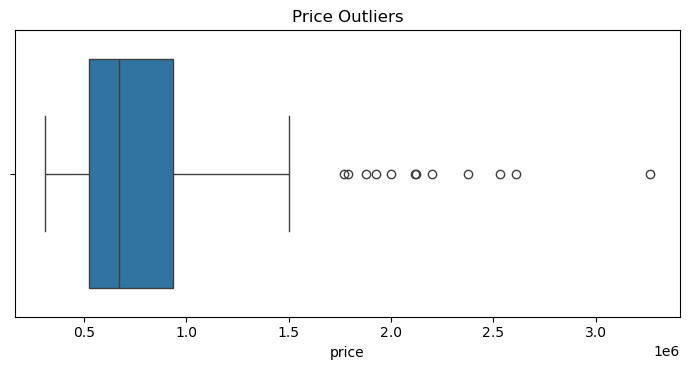

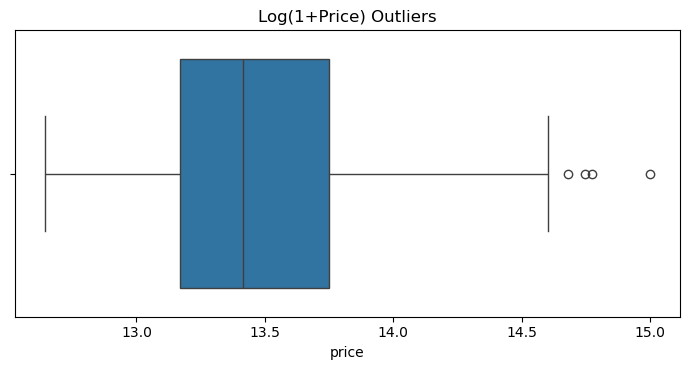

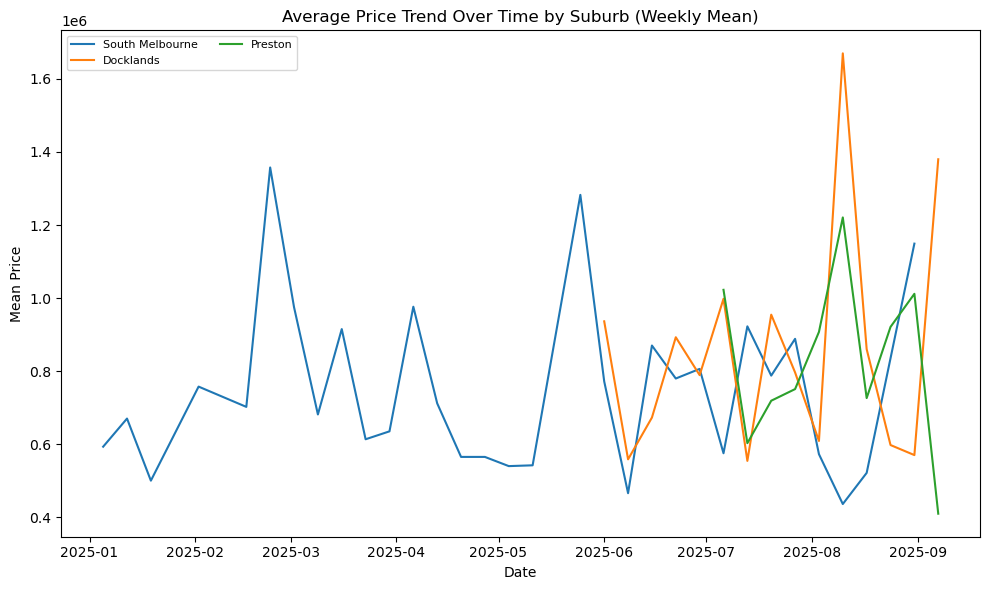

In [ ]:
# Price distribution & log-price distribution
plt.figure(figsize=(7,4))
sns.histplot(df["price"], kde=True)
plt.title("Housing Price Distribution")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
sns.histplot(np.log1p(df["price"]), kde=True)
plt.title("Log(1+Price) Distribution")
plt.tight_layout()
plt.show()

# Correlations (numeric only, include engineered features)
corr_cols = [c for c in df.columns if df[c].dtype != "O" and c != "price"]
corr_df = df[corr_cols + ["price"]].copy()
plt.figure(figsize=(10,8))
sns.heatmap(corr_df.corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap (Numerics)")
plt.tight_layout()
plt.show()
# Outliers (boxplot) on price & log-price
plt.figure(figsize=(7,3.8))
sns.boxplot(x=df["price"])
plt.title("Price Outliers")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,3.8))
sns.boxplot(x=np.log1p(df["price"]))
plt.title("Log(1+Price) Outliers")
plt.tight_layout()
plt.show()

# Price trends over time by suburb (monthly mean)
trend = (
    df.dropna(subset=["date_sold"])
      .groupby([pd.Grouper(key="date_sold", freq="W"), "suburb"])["price"]
      .mean()
      .reset_index()
      .sort_values("date_sold")
)
plt.figure(figsize=(10,6))
if not trend.empty:
    sns.lineplot(data=trend, x="date_sold", y="price", hue="suburb", estimator=None, errorbar=None)
    plt.title("Average Price Trend Over Time by Suburb (Weekly Mean)")
    plt.xlabel("Date")
    plt.ylabel("Mean Price")
    plt.legend(loc="best", fontsize=8, ncol=2)
    plt.tight_layout()
    plt.show()

Model development

In [ ]:
def make_pipeline(estimator):
    return Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", estimator)
    ])

models = {
    "LinearRegression": make_pipeline(LinearRegression()),
    "RandomForest": make_pipeline(RandomForestRegressor(
        n_estimators=500, max_depth=None, random_state=42, n_jobs=-1
    )),
    "GradientBoosting": make_pipeline(GradientBoostingRegressor(
        random_state=42
    ))
}

scoring = {
    "mae": "neg_mean_absolute_error",
    "rmse": "neg_root_mean_squared_error",
    "r2": "r2"
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

rows = []
for name, pipe in models.items():
    cv = cross_validate(pipe, X, y, cv=kf, scoring=scoring, return_train_score=False)
    rows.append({
        "model": name,
        "MAE":  -np.mean(cv["test_mae"]),
        "RMSE": -np.mean(cv["test_rmse"]),
        "R2":    np.mean(cv["test_r2"])
    })

results = pd.DataFrame(rows).sort_values("RMSE")  # lower RMSE is better
print("\n=== Cross-validated Performance (5-fold) ===")
print(results)

# Pick best by lowest RMSE (you can choose by highest R2 / lowest MAE if preferred)
best_name = results.sort_values("RMSE").iloc[0]["model"]
best_pipe = models[best_name]
print(f"\nSelected best model (by RMSE): {best_name}")

# Fit best model on full data (you may prefer train/test split if you want a final holdout)
best_pipe.fit(X, y)

# Save trained pipeline + metadata for the app
joblib.dump({
    "pipeline": best_pipe,
    "feature_list": base_features,
    "categorical_features": categorical_features,
    "numeric_features": numeric_features
}, "price_model.pkl")

print("\nSaved model to price_model.pkl")


=== Cross-validated Performance (5-fold) ===
              model            MAE           RMSE        R2
2  GradientBoosting  125775.895170  199087.924753  0.787137
1      RandomForest  133168.288188  216870.733346  0.750703
0  LinearRegression  186270.336477  291875.937619  0.501166

Selected best model (by RMSE): GradientBoosting

Saved model to price_model.pkl


Feature importance

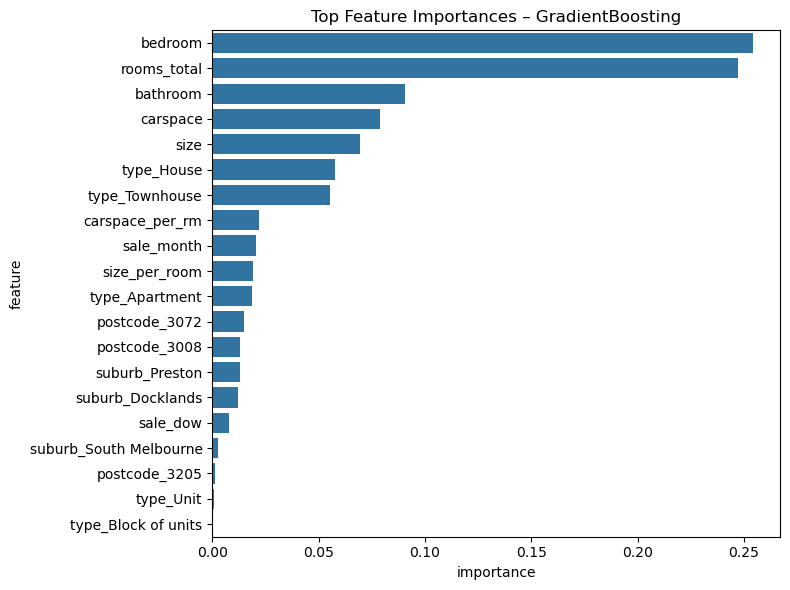

Saved tree-based feature importance to figs/feature_importance_tree.png


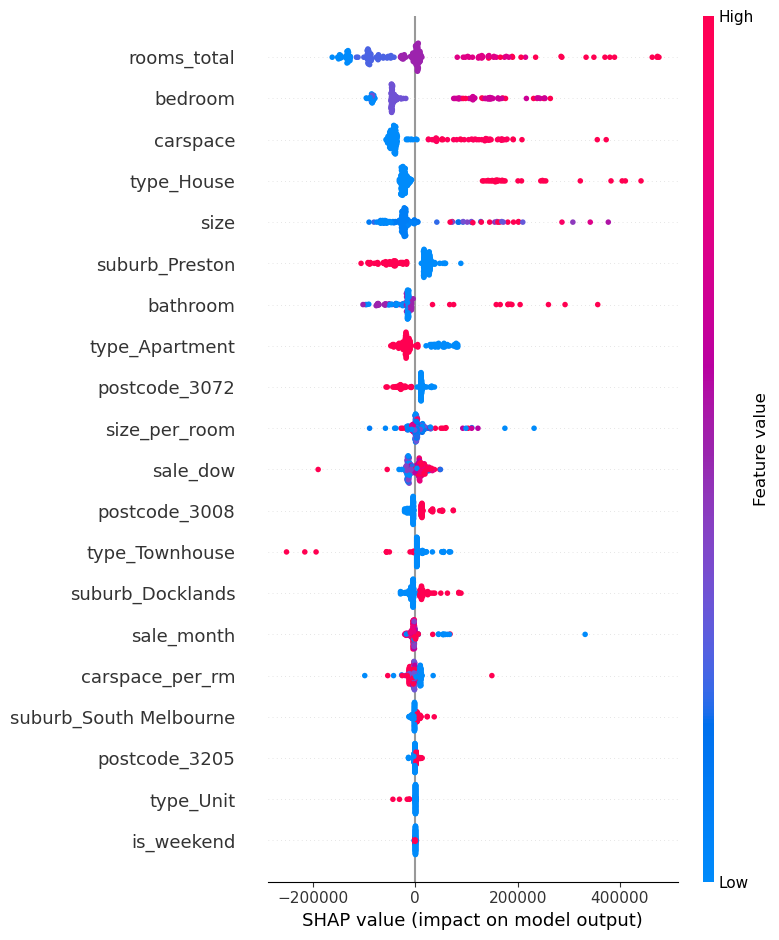

Saved SHAP summary plot to figs/shap_summary.png


In [ ]:
def get_feature_names(preprocessor, numeric_features, categorical_features):
    num_names = numeric_features
    cat_names = []
    # extract OHE names
    ohe = preprocessor.named_transformers_["cat"]["ohe"]
    cat_names = list(ohe.get_feature_names_out(categorical_features))
    return list(num_names) + cat_names

# Extract post-OHE+scale feature names
pre = best_pipe.named_steps["preprocess"]
feat_names = get_feature_names(pre, numeric_features, categorical_features)

# Model-based importance
model = best_pipe.named_steps["model"]
if hasattr(model, "feature_importances_"):
    importances = model.feature_importances_
    imp_df = pd.DataFrame({"feature": feat_names, "importance": importances})
    imp_df = imp_df.sort_values("importance", ascending=False).head(20)

    plt.figure(figsize=(8,6))
    sns.barplot(data=imp_df, x="importance", y="feature")
    plt.title(f"Top Feature Importances – {best_name}")
    plt.tight_layout()
    plt.show()
    print("Saved tree-based feature importance to figs/feature_importance_tree.png")
else:
    print(f"{best_name} does not expose feature_importances_. Skipping tree-based plot.")

# SHAP for tree models (RandomForest/GradientBoosting)
try:
    import shap
    if best_name in ["RandomForest", "GradientBoosting"]:
        # Build a background sample
        X_trans = pre.fit_transform(X)  # ensure same transform
        # Use a small random subset for speed
        idx = np.random.RandomState(42).choice(len(X_trans), size=min(200, len(X_trans)), replace=False)
        X_bg = X_trans[idx]

        if best_name == "RandomForest":
            explainer = shap.TreeExplainer(model)
            shap_vals = explainer.shap_values(X_bg)
        else:
            explainer = shap.TreeExplainer(model)
            shap_vals = explainer.shap_values(X_bg)

        shap.summary_plot(shap_vals, features=X_bg, feature_names=feat_names, show=False)
        plt.tight_layout()
        plt.show()
        print("Saved SHAP summary plot to figs/shap_summary.png")
    else:
        print("SHAP is most interpretable with tree models; skipped for LinearRegression.")
except Exception as e:
    print(f"(SHAP importance skipped: {e})")

For the model deployment, I created a separate app.py using steamlit. The code of app.py is as follows...

In [ ]:
# # app.py
# # ------------------------------------------------------------
# # Step 5: Simple web demo
# #   - Loads price_model.pkl (pipeline)
# #   - Lets users input features
# #   - Returns price prediction
# # Run: streamlit run app.py
# # ------------------------------------------------------------

# import streamlit as st
# import pandas as pd
# import numpy as np
# import joblib

# st.set_page_config(page_title="Housing Price Predictor", page_icon="🏡", layout="centered")
# st.title("🏡 Housing Price Prediction")

# # Load trained pipeline & metadata
# art = joblib.load("price_model.pkl")
# pipe = art["pipeline"]
# feature_list = art["feature_list"]
# categorical_features = art["categorical_features"]
# numeric_features = art["numeric_features"]

# # To populate dropdowns nicely, we’ll load the original dataset
# raw = pd.read_csv("dataset.csv")
# if "address" in raw.columns: raw = raw.drop(columns=["address"])
# if "state"   in raw.columns: raw = raw.drop(columns=["state"])

# # Prepare options for categorical fields
# for col in ["suburb","postcode","type"]:
#     if col in raw.columns:
#         raw[col] = raw[col].fillna(raw[col].mode()[0])

# suburb_opts  = sorted(raw["suburb"].dropna().astype(str).unique())  if "suburb"  in raw.columns else []
# postcode_opts= sorted(raw["postcode"].dropna().astype(str).unique())if "postcode" in raw.columns else []
# type_opts    = sorted(raw["type"].dropna().astype(str).unique())    if "type"    in raw.columns else []

# with st.form("input-form"):
#     st.subheader("Enter Property Details")
#     c1, c2 = st.columns(2)
#     with c1:
#         suburb   = st.selectbox("Suburb", suburb_opts) if suburb_opts else st.text_input("Suburb")
#         postcode = st.selectbox("Postcode", postcode_opts) if postcode_opts else st.text_input("Postcode")
#         ptype    = st.selectbox("Property Type", type_opts) if type_opts else st.text_input("Type (House/Townhouse/Unit)")
#     with c2:
#         bedroom  = st.number_input("Bedrooms", min_value=0, max_value=10, value=4, step=1)
#         bathroom = st.number_input("Bathrooms", min_value=0, max_value=10, value=2, step=1)
#         carspace = st.number_input("Car Spaces", min_value=0, max_value=6, value=2, step=1)

#     size = st.number_input("Size (sqm)", min_value=0, max_value=2000, value=650, step=10)

#     # Date-related inputs (we’ll derive engineered features from these)
#     st.markdown("**Sale Date**")
#     sale_date = st.date_input("Select a sale date", None)

#     submitted = st.form_submit_button("Predict Price")

# if submitted:
#     # Build a single-row DataFrame with ALL features used during training
#     row = {f: np.nan for f in feature_list}

#     # Fill directly observed fields
#     row["suburb"]   = str(suburb) if "suburb" in feature_list else None
#     row["postcode"] = str(postcode) if "postcode" in feature_list else None
#     row["type"]     = str(ptype) if "type" in feature_list else None

#     row["bedroom"]  = float(bedroom) if "bedroom" in feature_list else None
#     row["bathroom"] = float(bathroom) if "bathroom" in feature_list else None
#     row["carspace"] = float(carspace) if "carspace" in feature_list else None
#     row["size"]     = float(size) if "size" in feature_list else None

#     # Engineered features
#     if sale_date is not None:
#         row["sale_year"]  = sale_date.year if "sale_year" in feature_list else None
#         row["sale_month"] = sale_date.month if "sale_month" in feature_list else None
#         # Monday=0 .. Sunday=6
#         row["sale_dow"]   = sale_date.weekday() if "sale_dow" in feature_list else None
#         row["is_weekend"] = 1 if sale_date.weekday() >= 5 else 0 if "is_weekend" in feature_list else None
#     else:
#         # Fallback reasonable defaults
#         if "sale_year" in feature_list:  row["sale_year"]  = 2025
#         if "sale_month" in feature_list: row["sale_month"] = 8
#         if "sale_dow" in feature_list:   row["sale_dow"]   = 5
#         if "is_weekend" in feature_list: row["is_weekend"] = 1

#     # rooms_total / size_per_room / carspace_per_rm
#     rooms_total = max(1.0, float(bedroom) + float(bathroom))
#     if "rooms_total" in feature_list:   row["rooms_total"] = rooms_total
#     if "size_per_room" in feature_list: row["size_per_room"] = float(size) / rooms_total if rooms_total > 0 else 0.0
#     if "carspace_per_rm" in feature_list: row["carspace_per_rm"] = float(carspace) / rooms_total if rooms_total > 0 else 0.0

#     # frequency encodings (approximate using current raw distribution)
#     if "suburb_freq" in feature_list and "suburb" in raw.columns:
#         row["suburb_freq"] = int((raw["suburb"] == suburb).sum())
#     if "postcode_freq" in feature_list and "postcode" in raw.columns:
#         row["postcode_freq"] = int((raw["postcode"] == postcode).sum())

#     X_input = pd.DataFrame([row], columns=feature_list)

#     # Predict
#     try:
#         price_pred = pipe.predict(X_input)[0]
#         st.success(f"Estimated Price: ${price_pred:,.0f}")
#     except Exception as e:
#         st.error(f"Prediction failed: {e}")
#         st.stop()

#     st.caption("Note: This is a demo model trained on the provided dataset; real-world predictions may differ.")